In [1]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")


In [2]:
# 2. Data Loading
# 👉 Adjust the path as necessary for your system
df = pd.read_csv("/content/adult 3.csv")

In [3]:
df.sample(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
34836,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,?,<=50K
41748,31,Private,209538,10th,6,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
11733,28,Private,259609,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,50,United-States,<=50K
39587,29,Private,114870,Some-college,10,Divorced,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
22705,58,Private,121111,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,Greece,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
#null values
df.isna().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


### Data Analysis

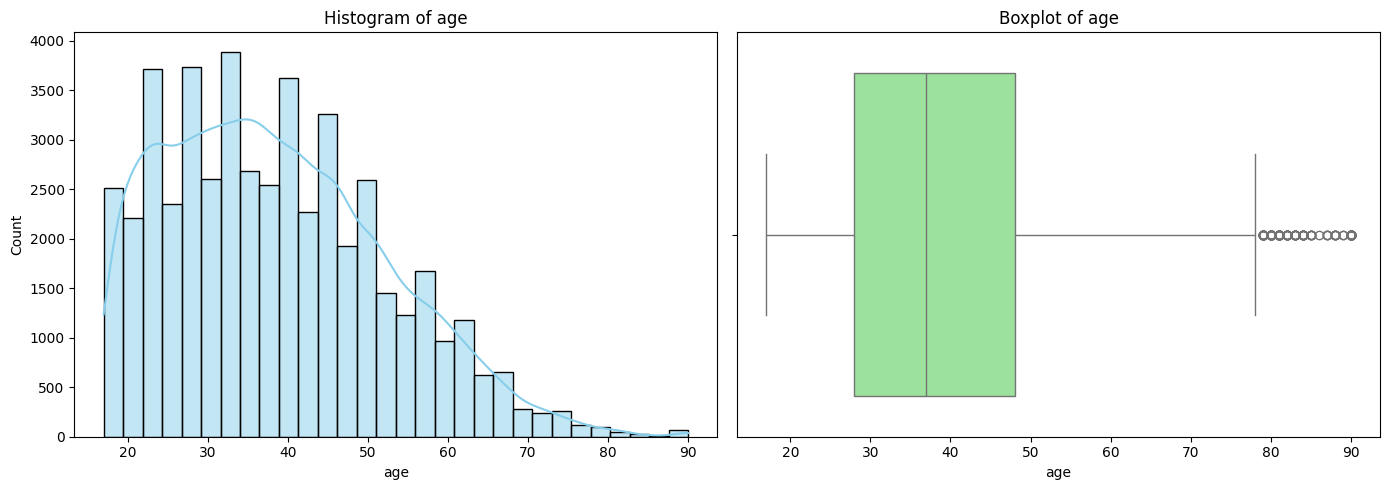

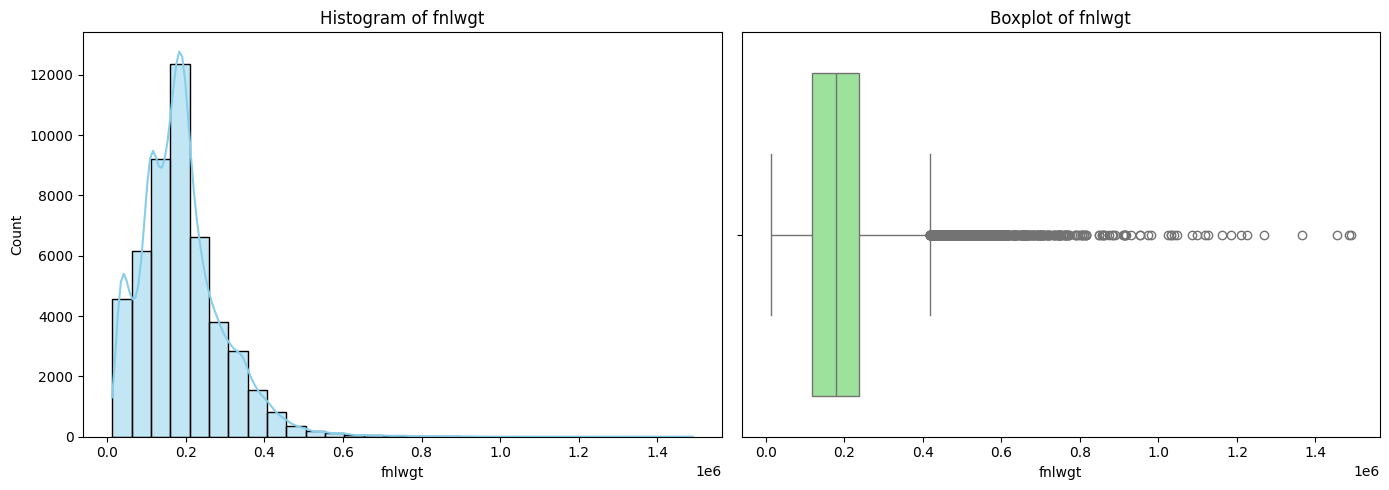

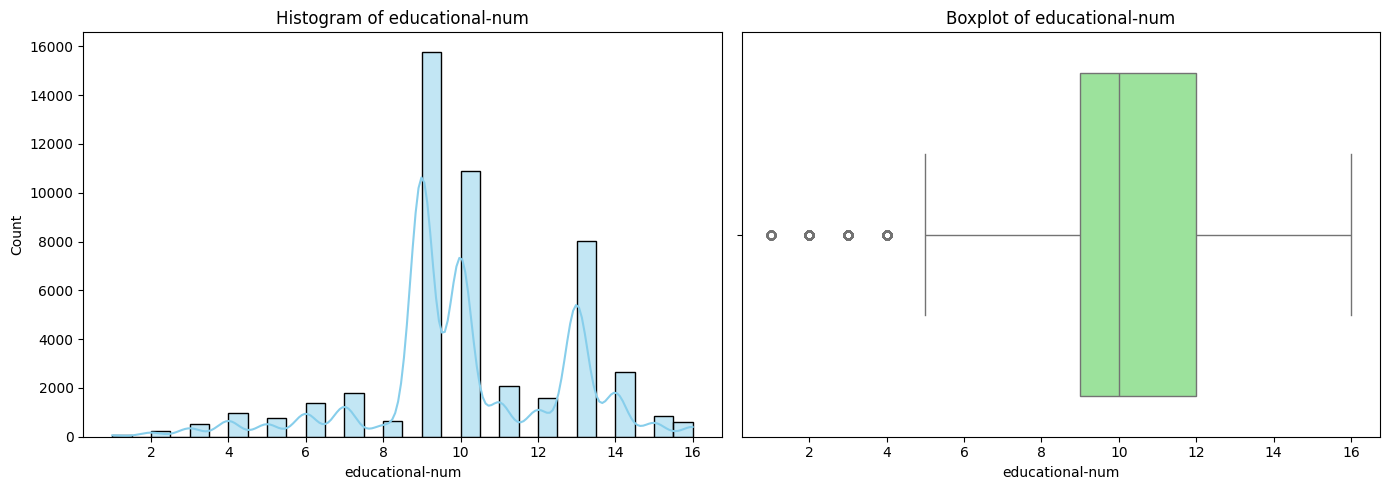

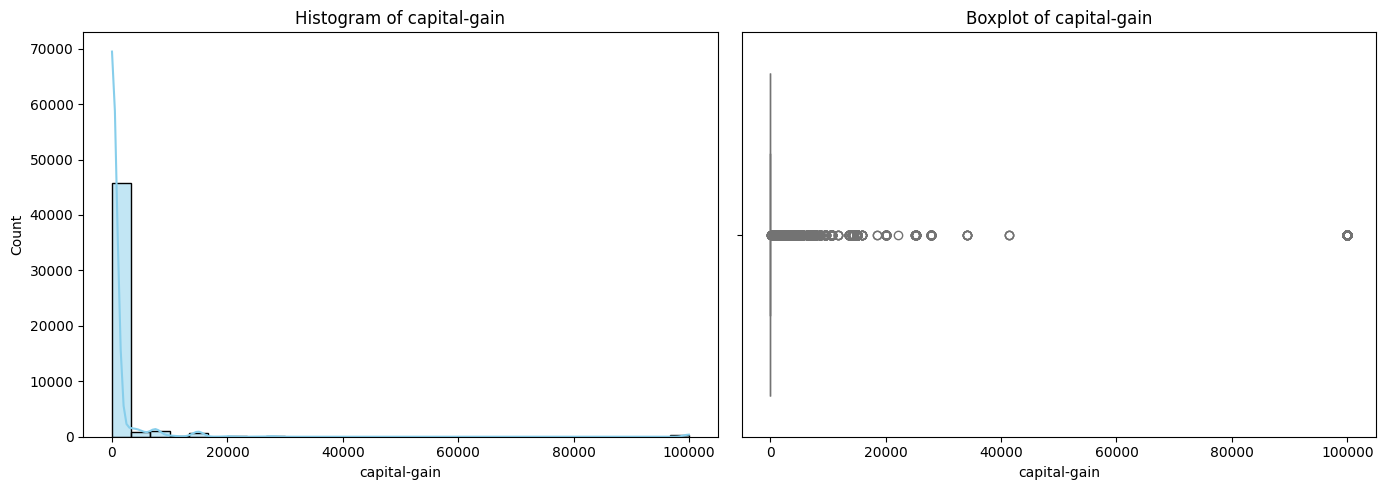

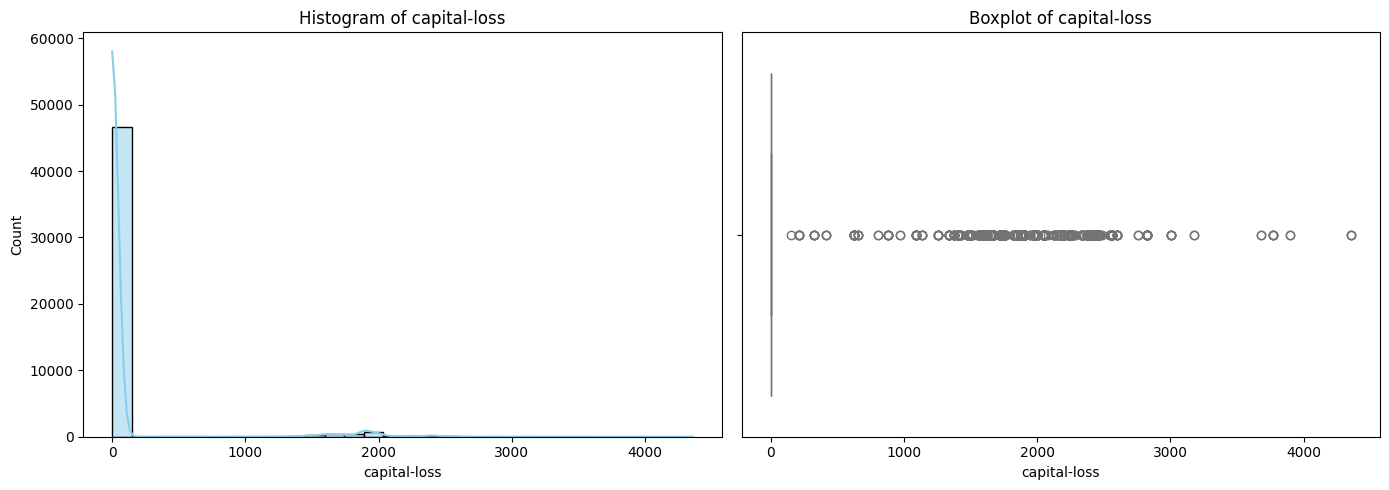

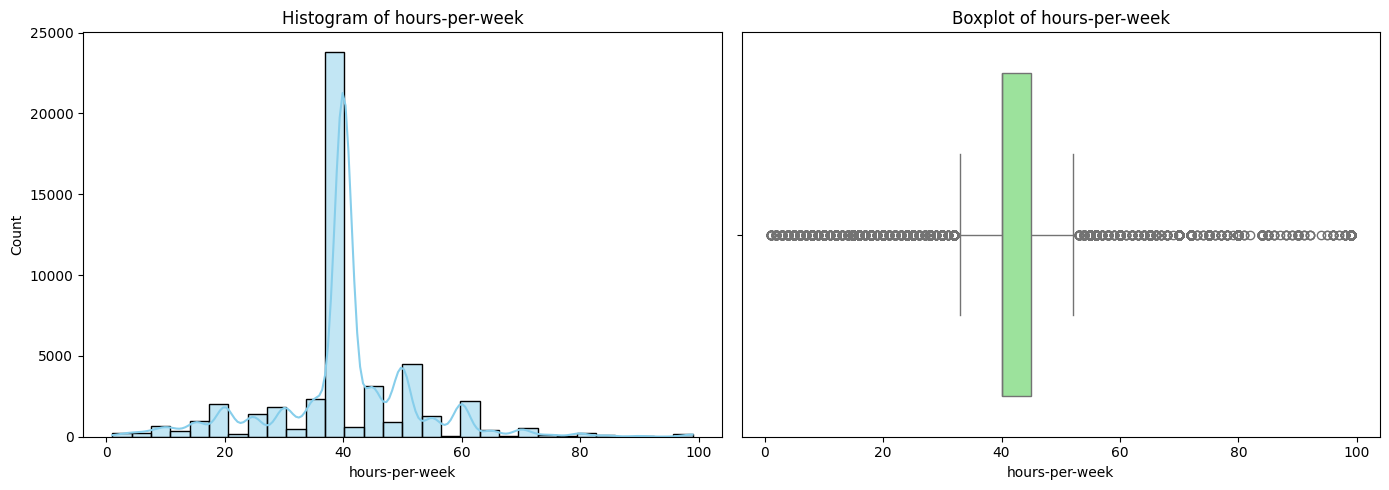

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numerical_features(df, num_cols=None):

    if num_cols is None:
        num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for col in num_cols:
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), bins=30, kde=True, color='skyblue')
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f'Boxplot of {col}')

        plt.tight_layout()
        plt.show()
plot_numerical_features(df)

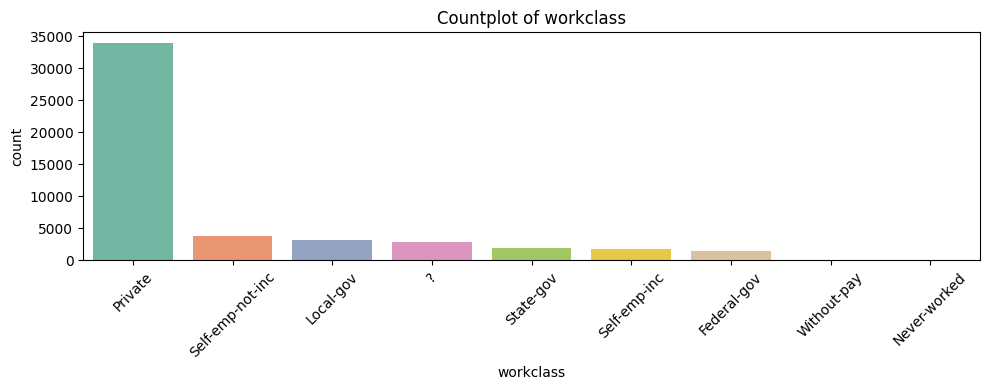

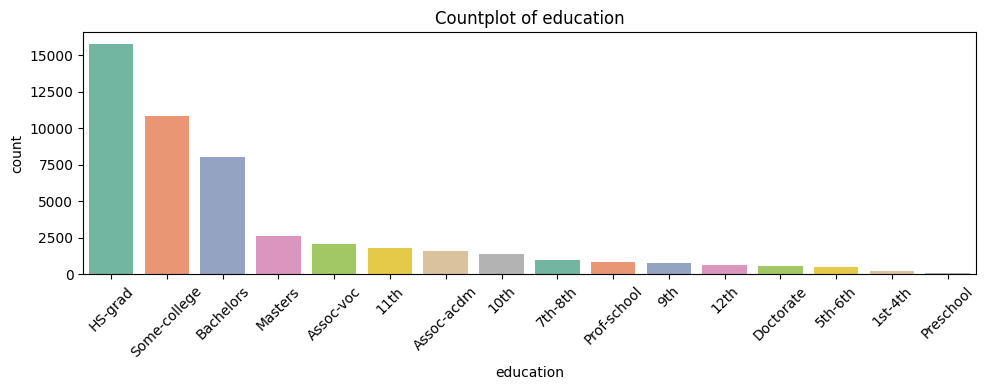

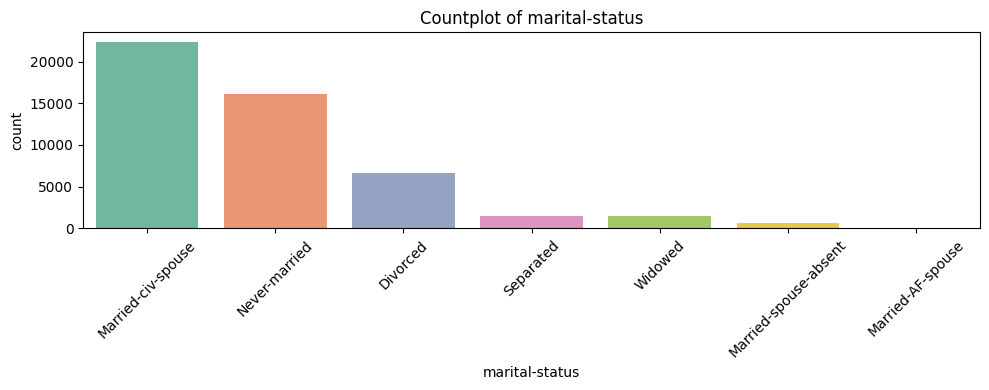

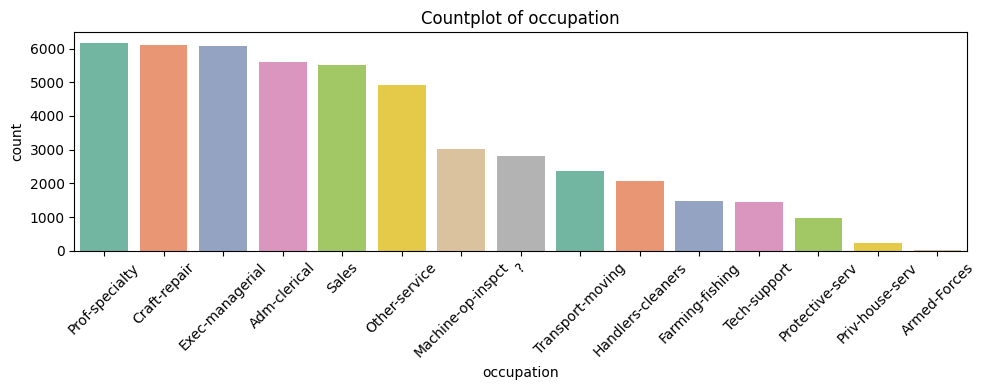

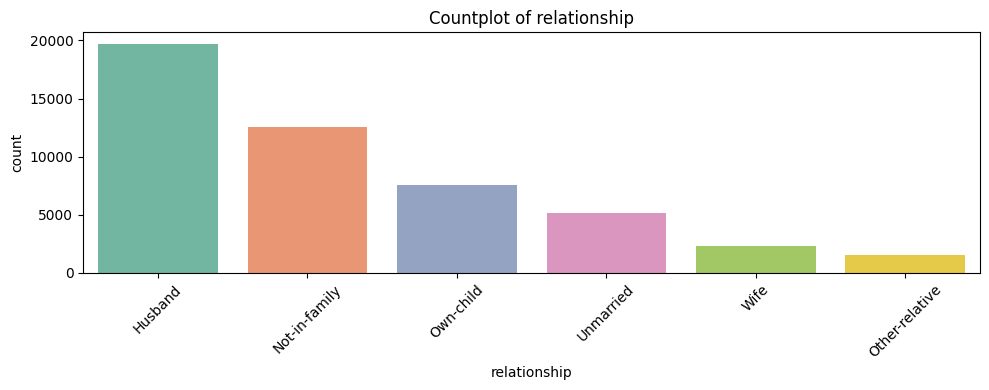

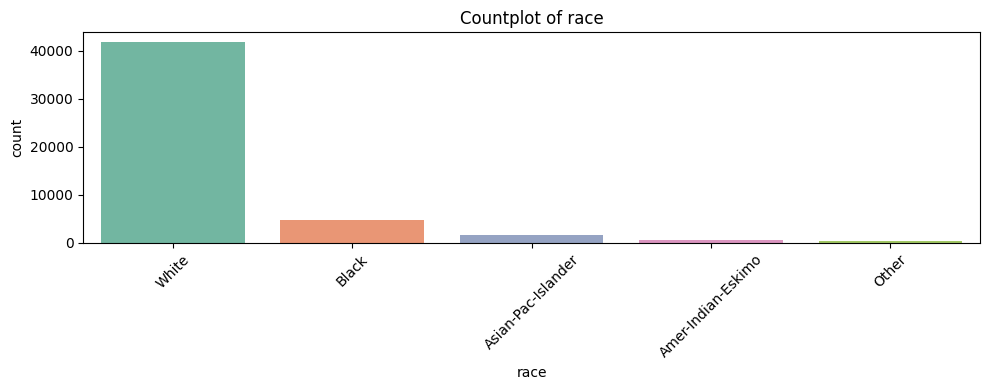

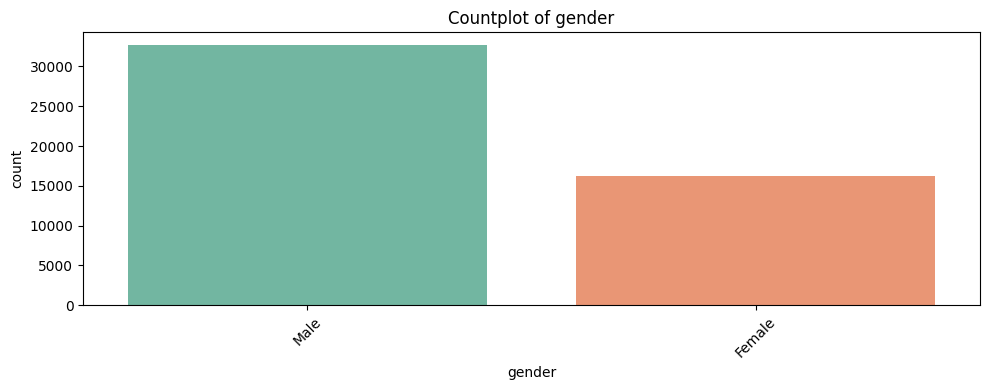

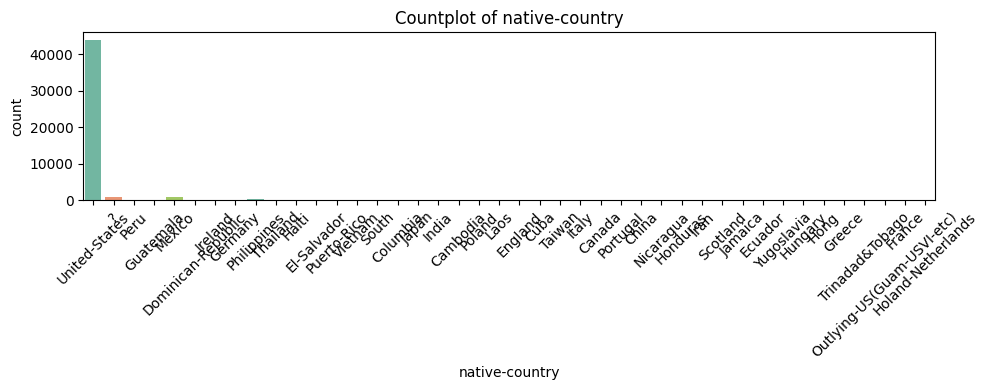

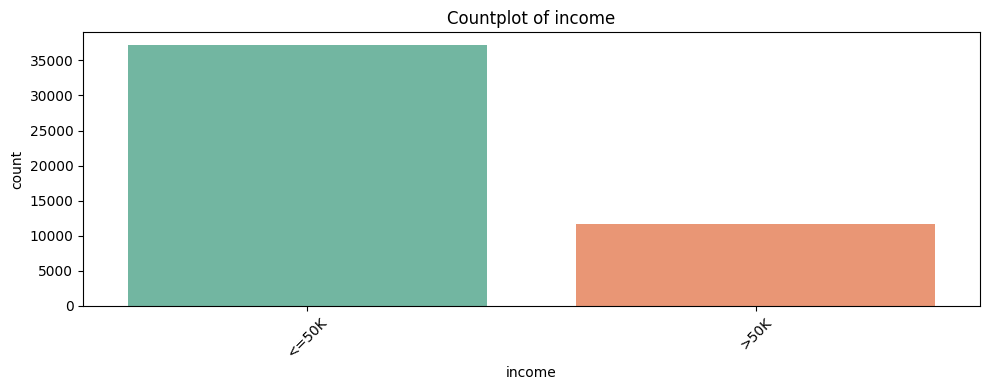

In [7]:
def plot_categorical_features(df, cat_cols=None):

    if cat_cols is None:
        cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    for col in cat_cols:
        plt.figure(figsize=(10, 4))
        order = df[col].value_counts().index if df[col].nunique() < 25 else None
        sns.countplot(data=df, x=col, order=order, palette='Set2')
        plt.title(f'Countplot of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_categorical_features(df)


### Data Cleaning & Feature Engineering

In [8]:
# Replace missing values and unify encoding of missing categorical values
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].replace(['?', 'Others'], 'Unknown')


In [9]:
df['workclass'].value_counts()

,count
workclass,
Private,33906
Self-emp-not-inc,3862
Local-gov,3136
Unknown,2799
State-gov,1981
Self-emp-inc,1695
Federal-gov,1432
Without-pay,21
Never-worked,10


In [10]:
df=df[df['workclass']!='Without-pay']
df=df[df['workclass']!='Never-worked']

In [11]:
df.relationship.value_counts()

,count
relationship,
Husband,19708
Not-in-family,12582
Own-child,7566
Unmarried,5123
Wife,2327
Other-relative,1505


In [12]:
#outlier detection
df=df[(df['age']<=75)&(df['age']>=18)]

In [13]:
df=df[(df['educational-num']<=16)&(df['educational-num']>=5)]

In [14]:
df=df.drop(columns=['education']) #redundant features removal

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46135 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              46135 non-null  int64 
 1   workclass        46135 non-null  object
 2   fnlwgt           46135 non-null  int64 
 3   educational-num  46135 non-null  int64 
 4   marital-status   46135 non-null  object
 5   occupation       46135 non-null  object
 6   relationship     46135 non-null  object
 7   race             46135 non-null  object
 8   gender           46135 non-null  object
 9   capital-gain     46135 non-null  int64 
 10  capital-loss     46135 non-null  int64 
 11  hours-per-week   46135 non-null  int64 
 12  native-country   46135 non-null  object
 13  income           46135 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.3+ MB


In [16]:
# Net capital
df['net_capital'] = df['capital-gain'] - df['capital-loss']

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [23]:
# 4. Define Features & Target
feature_cols = [col for col in df.columns if col not in ['income']]
X = df[feature_cols]
y = df['income']

In [24]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report


# 2. Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 3. Define Models with Sample Hyperparameters
rf = RandomForestClassifier(
    n_estimators=300, max_depth=12, min_samples_split=6, n_jobs=-1, random_state=42
)
xgb = XGBClassifier(
    n_estimators=350, max_depth=8, learning_rate=0.08, subsample=0.9, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1
)
lgbm = LGBMClassifier(
    n_estimators=350, max_depth=8, learning_rate=0.08, subsample=0.9, colsample_bytree=0.8,
    random_state=42, n_jobs=-1
)

ensemble = VotingClassifier(
    estimators=[('RandomForest', rf), ('XGBoost', xgb), ('LightGBM', lgbm)],
    voting='soft', n_jobs=-1
)

models = [rf, xgb, lgbm, ensemble]
names = ['RandomForest', 'XGBoost', 'LightGBM', 'Ensemble']

# 4. Cross-Validation Scores
print("Stratified K-Fold Cross-Validation Scores:")
for model, name in zip(models, names):
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

# 5. Cross-validated Classification Report for Ensemble Model
print("\nClassification Report for Ensemble Voting Classifier:")
y_pred = cross_val_predict(ensemble, X, y, cv=skf, n_jobs=-1)
print(classification_report(y, y_pred))


Stratified K-Fold Cross-Validation Scores:
RandomForest: 0.8580 ± 0.0051
XGBoost: 0.8681 ± 0.0063
LightGBM: 0.8695 ± 0.0050
Ensemble: 0.8693 ± 0.0049

Classification Report for Ensemble Voting Classifier:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     34606
           1       0.79      0.65      0.71     11529

    accuracy                           0.87     46135
   macro avg       0.84      0.79      0.81     46135
weighted avg       0.86      0.87      0.86     46135



In [25]:
import joblib

joblib.dump(ensemble, 'salary_prediction_model.pkl')


['salary_prediction_model.pkl']

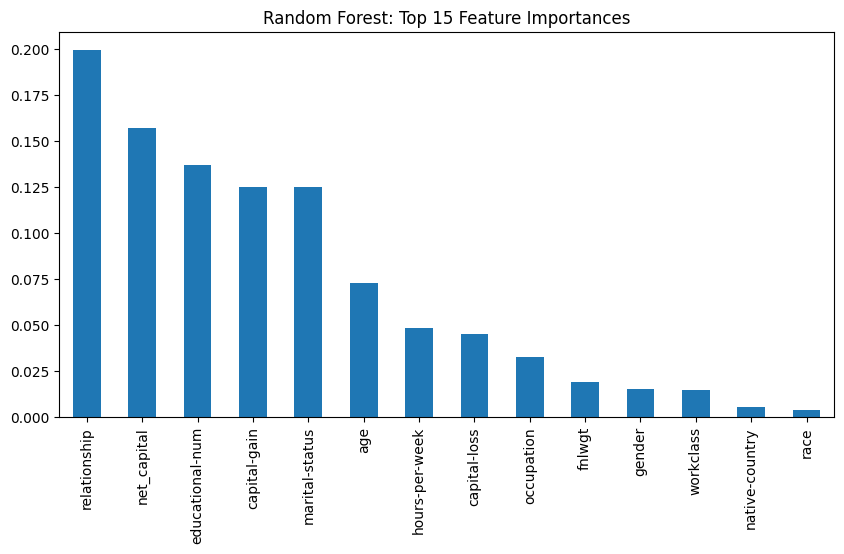

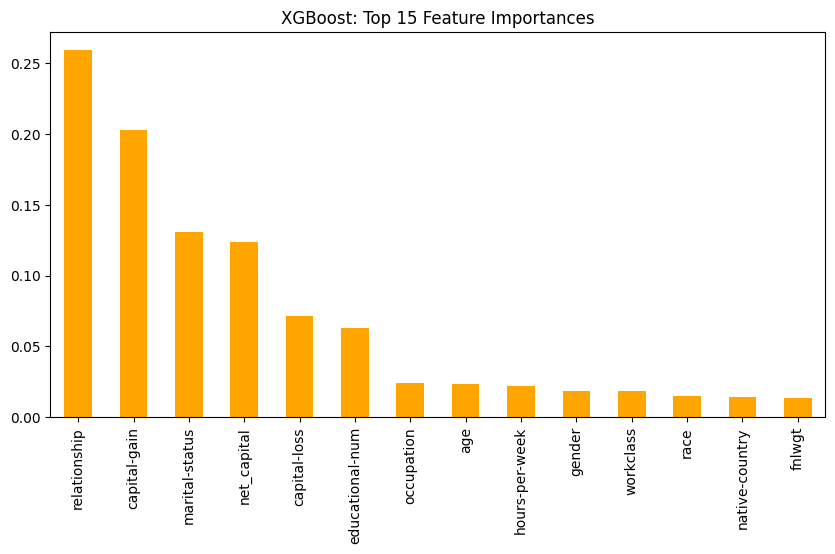

In [26]:
# 9. Feature Importance (from Random Forest and XGBoost)
import matplotlib.pyplot as plt

# Random Forest feature importance
rf.fit(X, y)
rf_feat_impt = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
rf_feat_impt[:15].plot(kind='bar')
plt.title('Random Forest: Top 15 Feature Importances')
plt.show()

# XGBoost feature importance
xgb.fit(X, y)
xgb_feat_impt = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
xgb_feat_impt[:15].plot(kind='bar', color='orange')
plt.title('XGBoost: Top 15 Feature Importances')
plt.show()


